In [89]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import model_selection , preprocessing
from sklearn.utils import shuffle

from daml import plot

In [90]:
# signal
s0 = pd.read_csv ( "signal.csv" )
s1 = pd.read_csv ( "0.csv" )
s2 = pd.read_csv ( "30.csv" )
s3 = pd.read_csv ( "60.csv" )

# bkg
b1 = pd.read_csv ( "sideband.csv" )
b2 = pd.read_csv ( "nearsignal.csv" )

In [91]:
# total bkg
b = pd.concat([b1,b2])
b = shuffle(b,random_state=42).reset_index(drop=True)
b.head()

,phib,phif,phitstar,phiw,t,thetab,thetaf,thetah,thetat,thetaw,tt,tth,isSignal
0,2.920753,1.090986,1.733981,0.137239,268.494580,0.653567,0.682121,0.917943,0.971721,0.566443,1268.745280,1430.672788,0
1,2.835025,1.946042,1.402751,2.896944,201.750574,0.781232,-0.180910,-0.915062,0.501745,0.743011,716.177864,923.922878,0
2,2.973645,2.530269,1.016207,1.918484,291.116294,0.412756,-0.916697,-0.677089,0.732552,0.761561,673.165946,807.950518,0
3,1.654473,1.665302,2.096471,0.131641,315.002068,0.144500,-0.940423,0.789105,0.133557,0.407656,837.942784,977.678059,0
4,2.122228,1.143082,0.394234,0.968614,235.680119,0.006688,0.710969,-0.932373,0.739628,0.535162,523.067557,702.426124,0


In [92]:
c0 = ['phib', 'phif', 'phitstar', 'phiw', 't', 'thetab', 'thetaf', 'thetah','thetat', 'thetaw', 'tt', 'tth']
Answer_to_all_questions = 42

In [93]:
# dftrain, dfeval, y_train, y_eval 
def preprocess(s, b):
    # sample signal
    S0 = s.sample(b.shape[0], random_state=42)

    # training dataset
    train0 = pd.concat([S0,b])

    # Shuffle training dataset
    train0 = shuffle(train0,random_state=42).reset_index(drop=True)
    
    # Standardize
    sc0 = preprocessing . StandardScaler ()
    input_data0 = sc0 . fit_transform ( train0[c0[0:12]] )
    target0 = train0['isSignal']

    # set random seed
    Answer_to_all_questions = 42
    # train - test split of dataset
    train_data0 , test_data0 , train_target0 , test_target0 = model_selection . train_test_split (\
    input_data0 , target0 , test_size =0.3 , random_state = Answer_to_all_questions )
    
    return  train_data0 , test_data0 , train_target0 , test_target0

## signal vs. background

In [94]:
from sklearn . ensemble import GradientBoostingClassifier
from sklearn . model_selection import GridSearchCV

from sklearn . model_selection import cross_val_score
from sklearn . model_selection import KFold
from sklearn . pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_curve

from dt_utils import *
from nn_utils import *

In [95]:
train_data0 , test_data0 , train_target0 , test_target0 = preprocess(s0,b)

In [96]:
print ( train_data0 . shape , train_target0 . shape , test_data0 . shape , test_target0 . shape )

(15548, 12) (15548,) (6664, 12) (6664,)


In [97]:
param_grid_ = {
 'n_estimators' :[50,100] ,
 'learning_rate' : [0.1 , 0.05, 0.01] ,
 'max_depth' :[5 , 10] ,
 'min_samples_leaf' :[50 ,100] ,
 'max_depth' :[5,10] 
}
njobs_ = 12 # jobs to run in parallel

In [98]:
kfold = KFold ( n_splits =10 , random_state = Answer_to_all_questions , shuffle = True )

In [99]:
# Grid search
gbc = GradientBoostingClassifier ()
classifier = GridSearchCV ( estimator = gbc , cv = kfold , param_grid = param_grid_ ,
n_jobs = njobs_ , verbose =1)
classifier . fit ( train_data0 , train_target0 .values. ravel ())

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   10.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 240 out of 240 | elapsed:  2.3min finished


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weigh...
                                                  n_iter_no_change=None,
                                                  presort='auto',
                

In [100]:
best0 = classifier . best_estimator_

In [101]:
best0 . fit ( train_data0 , train_target0.values.ravel ())

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=50, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

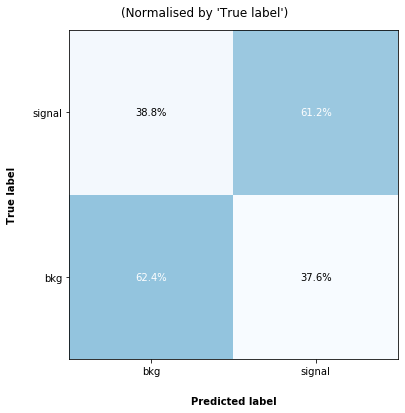

In [102]:
# Predictions
pred0 = best0.predict(test_data0)
        
# Define confusion matrix and classes
cm = confusion_matrix(test_target0,pred0)

names_ = ['bkg','signal']
plot.confusion_matrix (cm, labels=names_, normalise=True);

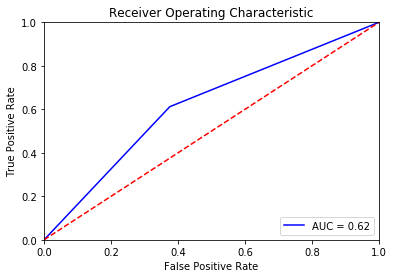

In [103]:
# Calculate false positive rate and true positive rate
fpr, tpr, threshold = roc_curve(test_target0, pred0)
roc_auc = metrics.auc(fpr, tpr)
# Plot ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [104]:
def importance(best):
    # Combine weights and variables
    data_tuples = list(zip(c0,(best.feature_importances_).tolist()))
    weight = pd.DataFrame(data_tuples, columns=['variable','weight'])
    # Rank by weight
    weight = weight.sort_values("weight",ascending=False)[["variable","weight"]]
    
    plt.figure(figsize=(8,5))
    plt.bar(weight['variable'],weight['weight'])
    plt.ylabel('weight')
    plt.title('Impact weights of input features')
    plt.show()
    return weight

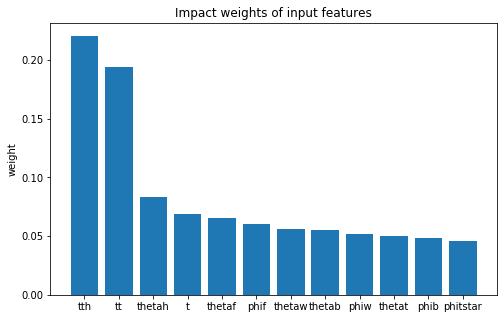

,variable,weight
11,tth,0.220556
10,tt,0.194174
7,thetah,0.083481
4,t,0.068484
6,thetaf,0.065722
1,phif,0.059979
9,thetaw,0.056200
5,thetab,0.054869
3,phiw,0.051985
8,thetat,0.050245


In [105]:
importance(best0)

## cp0 vs. bkg

In [106]:
train_data0 , test_data0 , train_target0 , test_target0 = preprocess(s1,b)

# Grid search
gbc = GradientBoostingClassifier ()
classifier = GridSearchCV ( estimator = gbc , cv = kfold , param_grid = param_grid_ ,
n_jobs = njobs_ , verbose =1)
classifier . fit ( train_data0 , train_target0 .values. ravel ())

# fit
best0 = classifier . best_estimator_
best0 . fit ( train_data0 , train_target0.values.ravel ())

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    9.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 240 out of 240 | elapsed:  2.3min finished


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=100, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

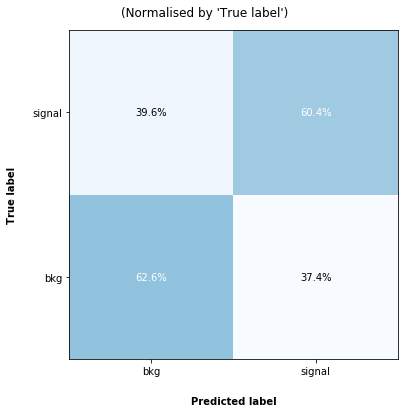

In [107]:
# Predictions
pred0 = best0.predict(test_data0)
        
# Define confusion matrix and classes
cm = confusion_matrix(test_target0,pred0)

names_ = ['bkg','signal']
plot.confusion_matrix (cm, labels=names_, normalise=True);

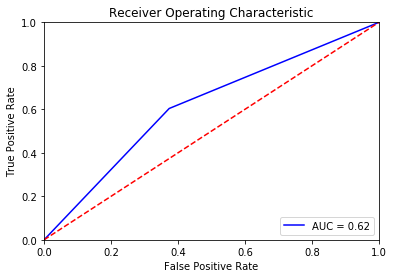

In [108]:
# Calculate false positive rate and true positive rate
fpr, tpr, threshold = roc_curve(test_target0, pred0)
roc_auc = metrics.auc(fpr, tpr)
# Plot ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

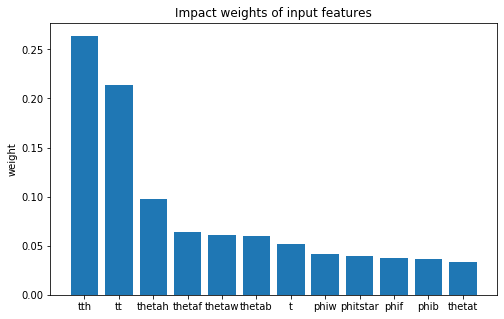

,variable,weight
11,tth,0.263654
10,tt,0.213860
7,thetah,0.097580
6,thetaf,0.064269
9,thetaw,0.060787
5,thetab,0.059843
4,t,0.051593
3,phiw,0.041581
2,phitstar,0.039741
1,phif,0.037236


In [109]:
importance(best0)

## cp30 vs bkg

In [110]:
train_data0 , test_data0 , train_target0 , test_target0 = preprocess(s2,b)

# Grid search
gbc = GradientBoostingClassifier ()
classifier = GridSearchCV ( estimator = gbc , cv = kfold , param_grid = param_grid_ ,
n_jobs = njobs_ , verbose =1)
classifier . fit ( train_data0 , train_target0 .values. ravel ())

# fit
best0 = classifier . best_estimator_
best0 . fit ( train_data0 , train_target0.values.ravel ())

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    9.6s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done 240 out of 240 | elapsed:  2.3min finished


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=100, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

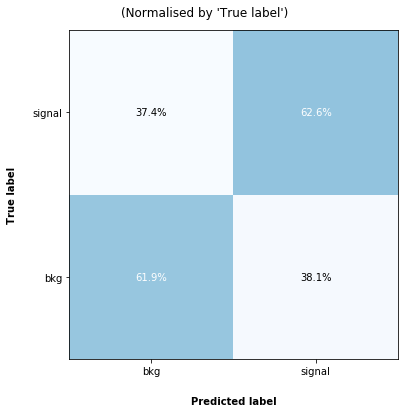

In [111]:
# Predictions
pred0 = best0.predict(test_data0)
        
# Define confusion matrix and classes
cm = confusion_matrix(test_target0,pred0)

names_ = ['bkg','signal']
plot.confusion_matrix (cm, labels=names_, normalise=True);

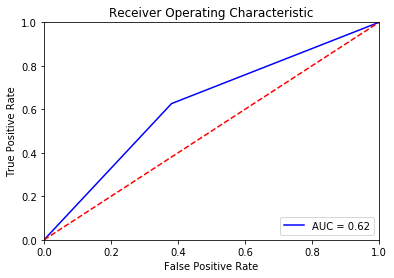

In [112]:
# Calculate false positive rate and true positive rate
fpr, tpr, threshold = roc_curve(test_target0, pred0)
roc_auc = metrics.auc(fpr, tpr)
# Plot ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

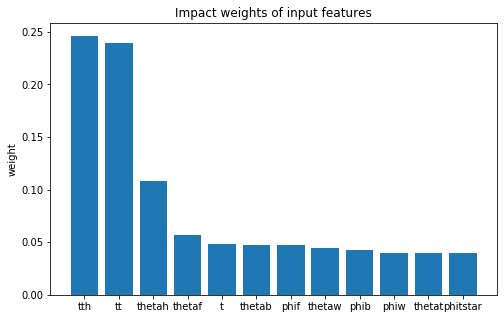

,variable,weight
11,tth,0.246095
10,tt,0.239357
7,thetah,0.108088
6,thetaf,0.056924
4,t,0.048118
5,thetab,0.047769
1,phif,0.047601
9,thetaw,0.044336
0,phib,0.042265
3,phiw,0.040095


In [113]:
importance(best0)

## cp60 vs bkg

In [114]:
train_data0 , test_data0 , train_target0 , test_target0 = preprocess(s3,b)

# Grid search
gbc = GradientBoostingClassifier ()
classifier = GridSearchCV ( estimator = gbc , cv = kfold , param_grid = param_grid_ ,
n_jobs = njobs_ , verbose =1)
classifier . fit ( train_data0 , train_target0 .values. ravel ())

# fit
best0 = classifier . best_estimator_
best0 . fit ( train_data0 , train_target0.values.ravel ())

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    9.3s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done 240 out of 240 | elapsed:  2.4min finished


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=100, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

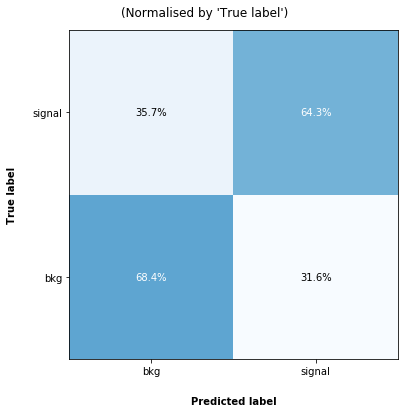

In [115]:
# Predictions
pred0 = best0.predict(test_data0)
        
# Define confusion matrix and classes
cm = confusion_matrix(test_target0,pred0)

names_ = ['bkg','signal']
plot.confusion_matrix (cm, labels=names_, normalise=True);

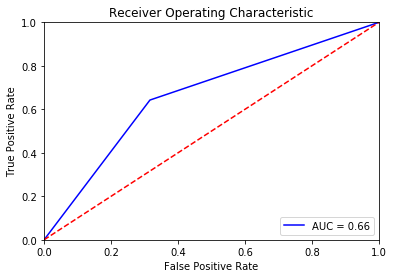

In [116]:
# Calculate false positive rate and true positive rate
fpr, tpr, threshold = roc_curve(test_target0, pred0)
roc_auc = metrics.auc(fpr, tpr)
# Plot ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

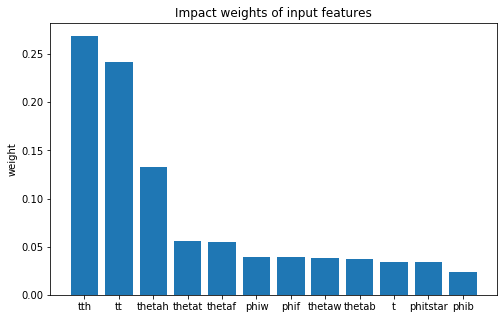

,variable,weight
11,tth,0.268842
10,tt,0.242258
7,thetah,0.132688
8,thetat,0.056252
6,thetaf,0.055127
3,phiw,0.039300
1,phif,0.039111
9,thetaw,0.038093
5,thetab,0.037071
4,t,0.034419


In [117]:
importance(best0)

## cp0 vs cp30 vs cp60

In [53]:
# dftrain, dfeval, y_train, y_eval 
def cp(a,b,c):
    
    shape = min(a.shape[0],b.shape[0],c.shape[0])
    a.insert(13,'alpha',0)
    b = b.sample(shape, random_state=42)
    b.insert(13,'alpha',1)
    c = c.sample(shape, random_state=42)
    c.insert(13,'alpha',2)
    
    # training dataset
    train0 = pd.concat([a,b,c])

    # Shuffle training dataset
    train0 = shuffle(train0,random_state=42).reset_index(drop=True)
    
    # Standardize
    sc0 = preprocessing . StandardScaler ()
    input_data0 = sc0 . fit_transform ( train0[c0[0:12]] )
    target0 = train0['alpha']

    # set random seed
    Answer_to_all_questions = 42
    # train - test split of dataset
    train_data0 , test_data0 , train_target0 , test_target0 = model_selection . train_test_split (\
    input_data0 , target0 , test_size =0.3 , random_state = Answer_to_all_questions )
    
    return train_data0 , test_data0 , train_target0 , test_target0

In [57]:
train_data0 , test_data0 , train_target0 , test_target0 = cp(s1,s2,s3)

In [58]:
best0 = GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=50, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

best0 . fit ( train_data0 , train_target0.values.ravel ())

      Iter       Train Loss   Remaining Time 
         1       87607.8273            3.53m
         2       87338.5717            3.43m
         3       87063.2404            3.46m
         4       86828.9616            3.33m
         5       86575.8653            3.25m
         6       86336.7681            3.17m
         7       86125.7199            3.07m
         8       85917.9785            3.01m
         9       85707.9758            2.95m
        10       85514.7073            2.89m
        20       83918.6333            2.36m
        30       82859.3825            1.92m
        40       82124.6259            1.55m
        50       81529.4736            1.23m
        60       81026.5500           56.42s
        70       80674.2458           40.58s
        80       80323.6834           26.18s
        90       80025.0116           12.72s
       100       79728.1155            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=50, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

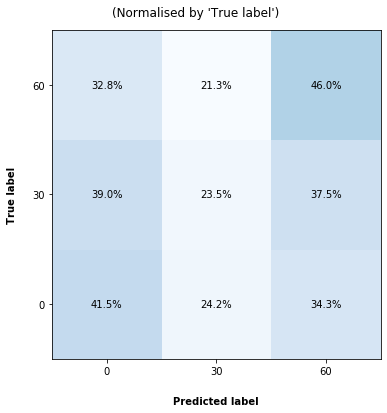

In [64]:
# Predictions
pred0 = best0.predict(test_data0)
        
# Define confusion matrix and classes
cm = confusion_matrix(test_target0,pred0)

plot.confusion_matrix (cm, labels=names_, normalise=True);

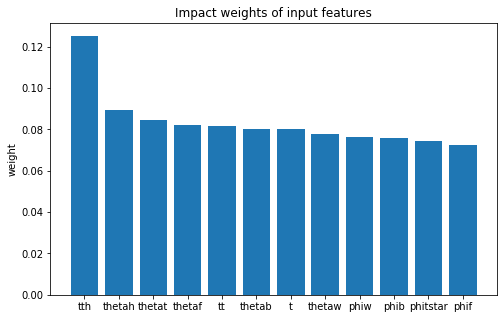

,variable,weight
11,tth,0.125199
7,thetah,0.089573
8,thetat,0.084727
6,thetaf,0.081992
10,tt,0.081653
5,thetab,0.080401
4,t,0.080168
9,thetaw,0.077835
3,phiw,0.076228
0,phib,0.075647


In [65]:
importance(best0)